In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import scale

import graspy.plot as gp
import matplotlib.pyplot as plt
%matplotlib inline

/home/ronak/pl/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


The data is in the form of $(x_t, y_t) \in \mathbb{R}^d \times \mathbb{R}$ input-response valued time series, where each feature vector contains some weather and mobility related data and the output is a some electrical load value. The data exists both at the city level, as well as at the level of larger regions, where the load valu is aggregated and the features are concatenated for every city in the region. We first read the column names from the annotated file for the New York region, and apply these names to the (unannotated) city level data for visualization.

In [2]:
df1 = pd.read_csv("Data_Processed_New/NYISO_mobility_annotated.csv") # this one has headers, so we directly store as pandas
df2 = np.genfromtxt('Data_Processed_New/City_Level/Boston_mobility_all.csv', delimiter=',')
df1.head()

,Time,Load (MW),cloudcover,humidity,precipMM,pressure,tempC,cloudcover.1,humidity.1,precipMM.1,...,Residential,Driving.1,Transit.1,Walking.1,Retail & recreation.1,Grocery & pharmacy.1,Parks.1,Transit stations.1,Workplaces.1,Residential.1
0,2/15/2020 0:00,18171,0,35,0.0,1035,-5,47,88,0.0,...,0,95.25,92.73,79.86,11,-3,21,9,0,0
1,2/15/2020 1:00,17525,0,35,0.0,1035,-5,32,88,0.0,...,0,95.25,92.73,79.86,11,-3,21,9,0,0
2,2/15/2020 2:00,17088,0,36,0.0,1036,-4,18,87,0.0,...,0,95.25,92.73,79.86,11,-3,21,9,0,0
3,2/15/2020 3:00,16846,0,36,0.0,1036,-4,4,86,0.0,...,0,95.25,92.73,79.86,11,-3,21,9,0,0
4,2/15/2020 4:00,16728,0,36,0.0,1036,-4,3,86,0.0,...,0,95.25,92.73,79.86,11,-3,21,9,0,0


Because the New York data contains NYC and Syracuse features, the weather and mobility data is repeated twice. The (sets of) columns, in order, are:
1. Date and timestamp in standard format.
2. The load.
3. Weather features (repeated twice).
4. One-hot encoded date and timestamp.
4. An indicator of whether the date is a holiday.
5. Mobility features (repeated twice).

In [3]:
df_cols = np.array(df1.columns)
print(df_cols)

['Time' 'Load (MW)' 'cloudcover' 'humidity' 'precipMM' 'pressure' 'tempC'
 'cloudcover.1' 'humidity.1' 'precipMM.1' 'pressure.1' 'tempC.1'
 'Index:Sun' 'Index:Mon' 'Index:Tue' 'Index:Wed' 'Index:Thu' 'Index:Fri'
 'Index:Sat' 'hour0' 'hour1' 'hour2' 'hour3' 'hour4' 'hour5' 'hour6'
 'hour7' 'hour8' 'hour9' 'hour10' 'hour11' 'hour12' 'hour13' 'hour14'
 'hour15' 'hour16' 'hour17' 'hour18' 'hour19' 'hour20' 'hour21' 'hour22'
 'hour23' 'Holiday' 'Driving' 'Transit' 'Walking' 'Retail & recreation'
 'Grocery & pharmacy' 'Parks' 'Transit stations' 'Workplaces'
 'Residential' 'Driving.1' 'Transit.1' 'Walking.1' 'Retail & recreation.1'
 'Grocery & pharmacy.1' 'Parks.1' 'Transit stations.1' 'Workplaces.1'
 'Residential.1']


We collect these names and use them to annotate the Boston data, which does not have column names, or a timestamp column.

In [4]:
response_col_name = df_cols[1]
weather_col_names = df_cols[2:7]
timestamp_col_names = df_cols[12:43]
holiday_col_names = [df_cols[43]]
mobility_col_names = df_cols[44:53]
col_names = np.concatenate((weather_col_names, holiday_col_names, mobility_col_names))

# The columns in the Boston data (df2) which correspond to the weather and mobility features, and not the timestamps.
data_cols = np.r_[1:1+len(weather_col_names), len(holiday_col_names)+len(weather_col_names)+len(timestamp_col_names):df2.shape[1]]

data = pd.DataFrame(data=df2[:, data_cols], columns = col_names)
data.head()

,cloudcover,humidity,precipMM,pressure,tempC,Holiday,Driving,Transit,Walking,Retail & recreation,Grocery & pharmacy,Parks,Transit stations,Workplaces,Residential
0,0.0,48.0,0.0,1034.0,-10.0,0.0,91.91,101.62,131.02,6.0,-2.0,6.0,1.0,-1.0,0.0
1,0.0,48.0,0.0,1034.0,-10.0,0.0,91.91,101.62,131.02,6.0,-2.0,6.0,1.0,-1.0,0.0
2,0.0,48.0,0.0,1035.0,-10.0,0.0,91.91,101.62,131.02,6.0,-2.0,6.0,1.0,-1.0,0.0
3,0.0,47.0,0.0,1035.0,-10.0,0.0,91.91,101.62,131.02,6.0,-2.0,6.0,1.0,-1.0,0.0
4,0.0,48.0,0.0,1035.0,-10.0,0.0,91.91,101.62,131.02,6.0,-2.0,6.0,1.0,-1.0,0.0


The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


For computation, the data will be represented as three `numpy` arrays for the features, timestamps, and labels, respectively. Ww wrap this into a function that can be used for any of the cities.

In [5]:
# The city_name field can take on "Boston", "Chicago", "Dallas", "Houston", "Phil", "SA", or "Seattle".
def load_data(city_name, standardize = False, verbose = False):
    df = np.genfromtxt('data/City_Level/%s_mobility_all.csv' % city_name, delimiter=',')
    
    X_weather = df[:, 1:1+len(weather_col_names)].astype(float)
    X_holiday = df[:, 1+len(holiday_col_names)+len(weather_col_names)+len(timestamp_col_names)].astype(float).reshape(-1, 1)
    X_mobility = df[:, 1+len(holiday_col_names)+len(weather_col_names)+len(timestamp_col_names):].astype(float)    
    X = np.hstack((X_weather, X_holiday, X_mobility))
    
    if standardize: X = scale(X)
    
    timestamps = df[:, 1+len(weather_col_names):1+len(weather_col_names)+len(timestamp_col_names)].astype(int)
    y = df[:, 0].astype(float)
    
    metadata = {"city_name" : city_name, 
                "X_weather" : X_weather, 
                "X_holiday": X_holiday,
                "X_mobility" : X_mobility, 
                "timestamps" : timestamps}

    if verbose:
        print(city_name, "Energy Consumption Data:")
        print("Sample size n =", X.shape[0])
        print("Number of weather features d_w =", X_weather.shape[1])
        print("Number of holiday features d_m =", X_holiday.shape[1])
        print("Number of mobility features d_m =", X_mobility.shape[1])
        print("Total number features d =", X.shape[1])
    
    return X, y, metadata

In [6]:
X, y, metadata = load_data("Seattle", standardize = True, verbose = True)

Seattle Energy Consumption Data:
Sample size n = 2184
Number of weather features d_w = 5
Number of holiday features d_m = 1
Number of mobility features d_m = 9
Total number features d = 15


Next, we display some of the pair plots for both of the data views for various cities, to see if the distributions (after standardization) have some common properties, correlated features, etc. Note that we are viewing crosscorrelation at lag one, respecting the time series structure of the data.

In [7]:
def pairplot(city_name):
    
    X, y, metadata = load_data(city_name, standardize = True, verbose = False)
    X_weather = metadata["X_weather"]
    X_mobility = metadata["X_mobility"]

    # Plot weather features.
    gp.pairplot(np.hstack((y.reshape((-1, 1)), X_weather)), 
                col_names=[response_col_name]+list(weather_col_names), 
                title=city_name + " Weather Pairplot",
                font_scale = 0.8,
                height=1.5)
    # Plot mobility features.
    gp.pairplot(np.hstack((y.reshape((-1, 1)), X_mobility)), 
                col_names=[response_col_name]+list(mobility_col_names), 
                title=city_name + " Mobility Pairplot",
                font_scale = 2.5,
                height=6,
                size = 300)

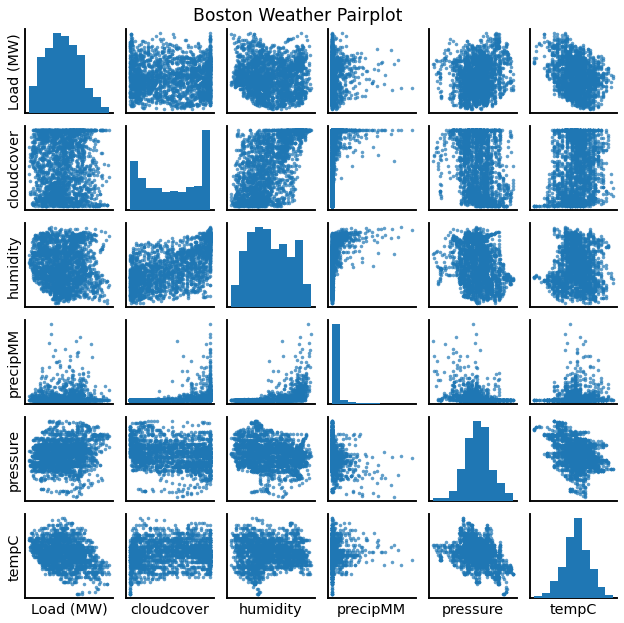

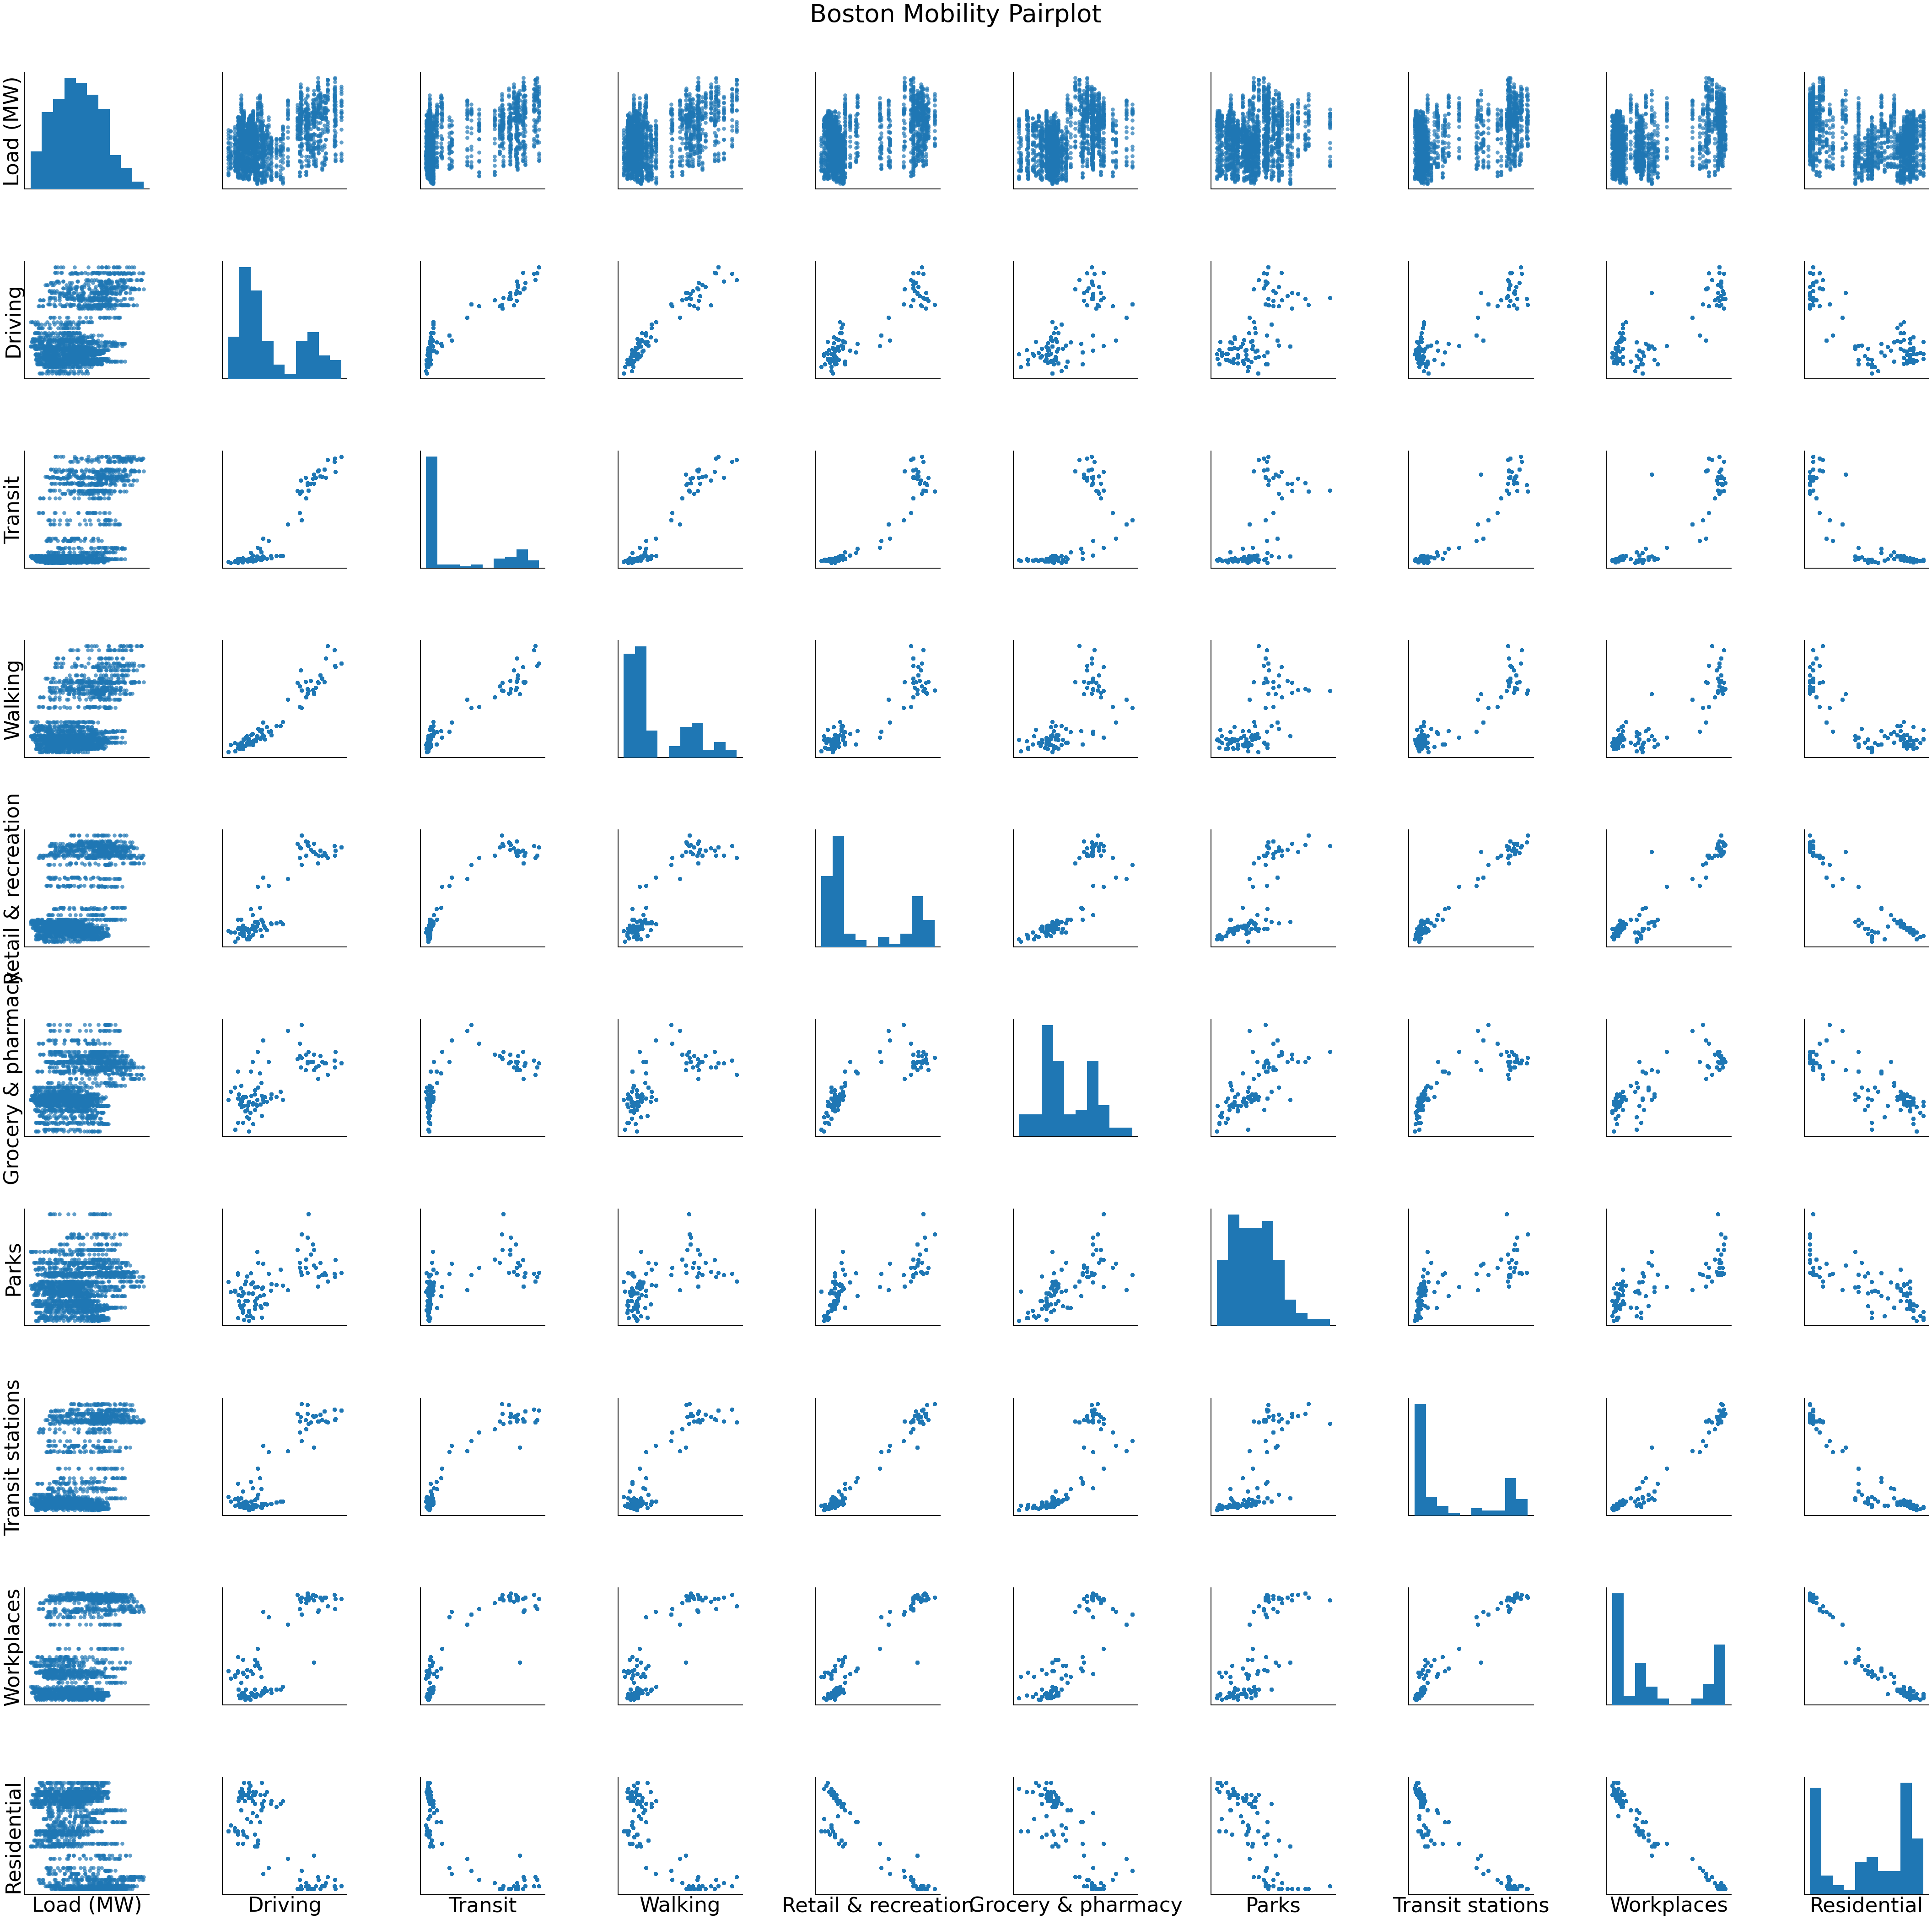

In [8]:
pairplot("Boston")

The mobility features are ALL highly correlated with one another. This may suggest that inference can be improved by linear dimension reduction, and that the entire feature space may be represented by say two features. Consequently, we then look at the scree plot of the mobility view.

In [9]:
def screeplot(city_name):
    X, y, metadata = load_data(city_name, standardize = True)
    X_mobility = metadata["X_mobility"]
    
    gp.screeplot(X_mobility, title=city_name+' Mobility Scree Plot')

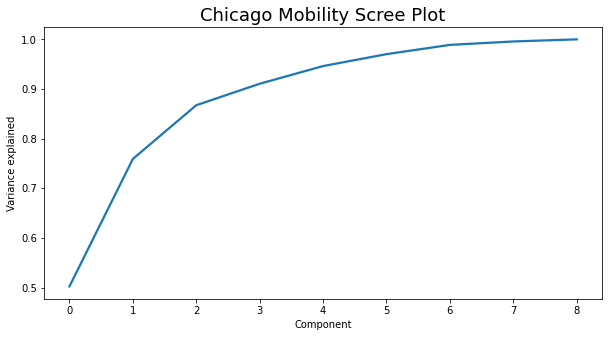

In [10]:
screeplot("Chicago")

Note this this is purely unsupervised. Next, we plot the $y_t$ series to determine a model that might fight this data well.

In [11]:
def plot_ts(city_name):
    X, y, metadata = load_data(city_name)
    n = len(y)
    
    fig, axes = plt.subplots(3, 1, figsize=(15,12), sharey = True)
    
    num_ind = 1
    scales = [24, 7, 4]
    periods = ["Day", "Week", "Month"]
    for i in range(3):
        num_ind *= scales[i]
        axes[i].plot(np.arange(num_ind), y[n-num_ind:n]) # day scale
        axes[i].set_title("Load over One %s" % periods[i])
    
    fig.suptitle("Response Series (%s)" % city_name)

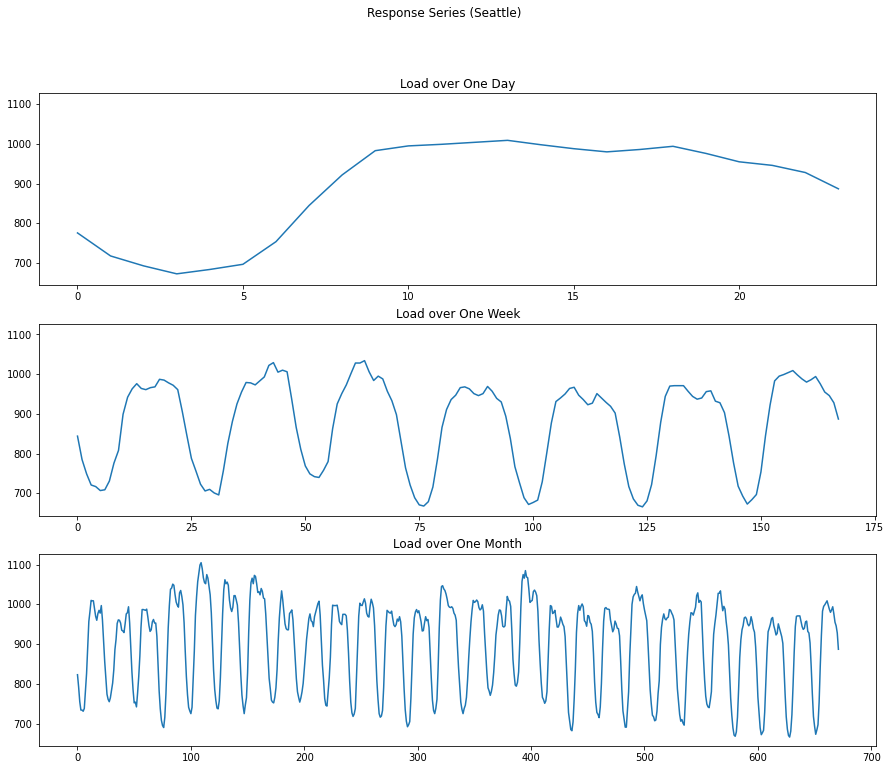

In [12]:
plot_ts("Seattle")